# Get Population Data from Google Earth Engine using GEEMap

In [1]:
import ee
import geemap

## Authenticate & Initialize GEE

Requires a [Google Cloud Project](https://console.cloud.google.com/projectcreate) and to enable the [Earth Engine API](https://console.cloud.google.com/apis/api/earthengine.googleapis.com) for the project. Find detailed instructions [here](https://book.geemap.org/chapters/01_introduction.html#earth-engine-authentication).

In [2]:
ee.Initialize()

## Create a GEEMap Object

In [3]:
# center over Sierra Leone
m = geemap.Map(
    center=[8.5, -11.5], 
    zoom=6, 
    basemap = 'Esri.WorldImagery',
    height = 800
)
m

Map(center=[8.5, -11.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [4]:
# get the current zoom and center of map
print(m.center, m.zoom)

[8.5, -11.5] 6.0


## Add Layers to the Map

In [5]:
# add WorldPop population density layer
# https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#description
dataset_pop = ee.ImageCollection('WorldPop/GP/100m/pop') \
                  .filter(ee.Filter.date('2020-01-01', '2020-12-31'))
pop = dataset_pop.select('population')
image_pop = pop.median()
popVis = {
    'min': 0.0, 
    'max': 20.0,
    'palette': ['24126c', '1fff4f', 'd4ff50'],
    'opacity': 0.5
}
m.addLayer(image_pop, popVis, 'Population')


In [6]:
# overlay country boundaries with white borders
countries = ee.FeatureCollection('FAO/GAUL/2015/level0')
m.addLayer(countries, {}, 'Countries')

# note: this isn't styling the countries correctly
# manually change the country layer to have a transparent fill on the interactive map
# note do not rerun these cells multiple times, seems to freeze the map

In [7]:
# add place names
# https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0
m.add_basemap('CartoDB.VoyagerOnlyLabels')
# m.remove_layer('CartoDB.VoyagerOnlyLabels') # doesn't work

## Import Sierra Leone Sites from PowerGen & CrossBoundary

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [27]:
# read in the data from data/sl 
sl_cbil_df = pd.read_csv('data/sl/sl_cbil_gdf.csv')
sl_pg_df = pd.read_csv('data/sl/sl_pg_gdf.csv')
sl_ctrl_df = pd.read_csv('data/sl/sl_ctrl_gdf.csv')

# convert to geodataframes using the "geometry" column as well known text
sl_cbil_gdf = gpd.GeoDataFrame(sl_cbil_df, geometry=gpd.GeoSeries.from_wkt(sl_cbil_df['geometry']))
sl_pg_gdf = gpd.GeoDataFrame(sl_pg_df, geometry=gpd.GeoSeries.from_wkt(sl_pg_df['geometry']))
sl_ctrl_gdf = gpd.GeoDataFrame(sl_ctrl_df, geometry=gpd.GeoSeries.from_wkt(sl_ctrl_df['geometry']))

# export as geojsons to data/sl_pop folder
sl_cbil_gdf.to_file('data/sl_pop/sl_cbil.geojson', driver='GeoJSON')
sl_pg_gdf.to_file('data/sl_pop/sl_pg.geojson', driver='GeoJSON')
sl_ctrl_gdf.to_file('data/sl_pop/sl_ctrl.geojson', driver='GeoJSON')

## Clean Up GeoDataFrames

In [28]:
import datetime as dt

In [29]:
# read back in the geojsons
sl_cbil_gdf = gpd.read_file('data/sl_pop/sl_cbil.geojson')
sl_pg_gdf = gpd.read_file('data/sl_pop/sl_pg.geojson')
sl_ctrl_gdf = gpd.read_file('data/sl_pop/sl_ctrl.geojson')


### Standardize Column Names

In [30]:
# add a column to tag where each site is from
sl_ctrl_gdf['site_type'] = 'Control'
sl_pg_gdf['site_type'] = 'PowerGen'
sl_cbil_gdf['site_type'] = 'CBIL'

# add a site name column
sl_ctrl_gdf['site_name'] = sl_ctrl_gdf['Community']
sl_pg_gdf['site_name'] = sl_pg_gdf['site_name']
sl_cbil_gdf['site_name'] = sl_cbil_gdf['site']

# add a date commissioned column
sl_ctrl_gdf['date_commissioned'] = '2030-01-01' # date way in the future
sl_pg_gdf['date_commissioned'] = sl_pg_gdf['date_commissioned']
# convert the metadataprojectcod column to datetime
sl_cbil_gdf['metadataprojectcod'] = pd.to_datetime(sl_cbil_gdf['metadataprojectcod'])
# convert the metadataprojectcod column to string
sl_cbil_gdf['date_commissioned'] = sl_cbil_gdf['metadataprojectcod'].dt.strftime('%Y-%m-%d')

# # check the date_commissioned column of sl_cbil_gdf
# sl_cbil_gdf['date_commissioned']

# re-export the geodataframes to geojosn
sl_cbil_gdf.to_file('data/sl_pop/sl_cbil.geojson', driver='GeoJSON')
sl_pg_gdf.to_file('data/sl_pop/sl_pg.geojson', driver='GeoJSON')
sl_ctrl_gdf.to_file('data/sl_pop/sl_ctrl.geojson', driver='GeoJSON')

### Drop Redundant CBIL & PG Sites

In [31]:
# drop the sites in cbil that have developer = "WindGen Power USA Inc. (PowerGen)"
sl_cbil_gdf = sl_cbil_gdf[sl_cbil_gdf['developer'] != "WindGen Power USA Inc. (PowerGen)"]

# remove the extra columns
sl_cbil_gdf = sl_cbil_gdf[['site_type', 'site_name', 'date_commissioned', 'geometry']]
sl_pg_gdf = sl_pg_gdf[['site_type', 'site_name', 'date_commissioned', 'geometry']]
sl_ctrl_gdf = sl_ctrl_gdf[['site_type', 'site_name', 'date_commissioned', 'geometry']]

# combine into 1 gdf
sl_gdf = pd.concat([sl_cbil_gdf, sl_pg_gdf, sl_ctrl_gdf])

# export to geojson
sl_gdf.to_file('data/sl_pop/sl.geojson', driver='GeoJSON')

### Remove Control Sites that are Duplicated

In [32]:
# read in sl_gdf
sl_gdf = gpd.read_file('data/sl_pop/sl.geojson')

# remove any duplicates by site_name that have site_type = "Control"
sl_gdf = sl_gdf[~((sl_gdf['site_type'] == 'Control') & (sl_gdf.duplicated(subset='site_name')))]

# remove the site "Manowa Junction" because it's coordinates are outside of Sierra Leone
sl_gdf = sl_gdf[sl_gdf['site_name'] != 'Manowa Junction']

# reexport to geojson
sl_gdf.to_file('data/sl_pop/sl.geojson', driver='GeoJSON')

## Get Population Values for Sierra Leone Sites

In [33]:
# recreate feature collection from geojson file
sl_fc = geemap.geojson_to_ee('data/sl_pop/sl.geojson')


In [34]:
# create 1km buffer around each site
# todo consider a 2km buffer
sl_fc_buffer = sl_fc.map(lambda f: f.buffer(1000))

In [35]:
# fetch entire worldpop image collection on the ee server
worldpop = ee.ImageCollection("WorldPop/GP/100m/pop")

# get worldpop images from the country Sierra Leone
worldpop_sl = worldpop.filter(ee.Filter.eq('country', 'SLE'))

# convert the worldpop_sl image collection into a single image with one band for each year
worldpop_sl = worldpop_sl.select('population')
worldpop_sl_stack = worldpop_sl.toBands()

# print the worldpop_sl_stack image
worldpop_sl_stack

In [36]:
# we can use the reduceRegions function to calculate the sum of the population within each buffer
# calculate the sum of the population within each buffer for every image "band"
sl_pop_fc = worldpop_sl_stack.reduceRegions(
    collection=sl_fc_buffer,
    reducer=ee.Reducer.sum(),
)

# convert the cicular buffers back to points
sl_pop_fc = sl_pop_fc.map(lambda feature: feature.centroid())

In [37]:
# export the feature collection to a geopandas dataframe
sl_pop_gdf = geemap.ee_to_geopandas(sl_pop_fc)

# replace all column names containing 'SLE_' with ''
sl_pop_gdf.columns = sl_pop_gdf.columns.str.replace('SLE_', '')
sl_pop_gdf.columns = sl_pop_gdf.columns.str.replace('_population', '')

# export the geopandas dataframe to a geojson file
sl_pop_gdf.to_file('data/sl_pop/sl_pop.geojson', driver='GeoJSON')

### Clean Up and Melt the DataFrame

In [38]:
# read in the geojson as gdf
sl_pop_gdf = gpd.read_file('data/sl_pop/sl_pop.geojson')
gdf = sl_pop_gdf

# melt the dataframe
gdf = gdf.melt(id_vars=['site_name', 'date_commissioned', 'site_type', 'geometry'], var_name='year', value_name='population')

# round the population column to integers
gdf['population'] = gdf['population'].round().astype(int)

# convert the year column to datetime
gdf['year'] = pd.to_datetime(gdf['year'], format='%Y')

# export the dataframe to a csv
gdf.to_file('data/sl_pop/sl_pop_melt.geojson', driver='GeoJSON')

## Visualize the Results

In [39]:
# plot the population of each site over time
import matplotlib.pyplot as plt
import seaborn as sns


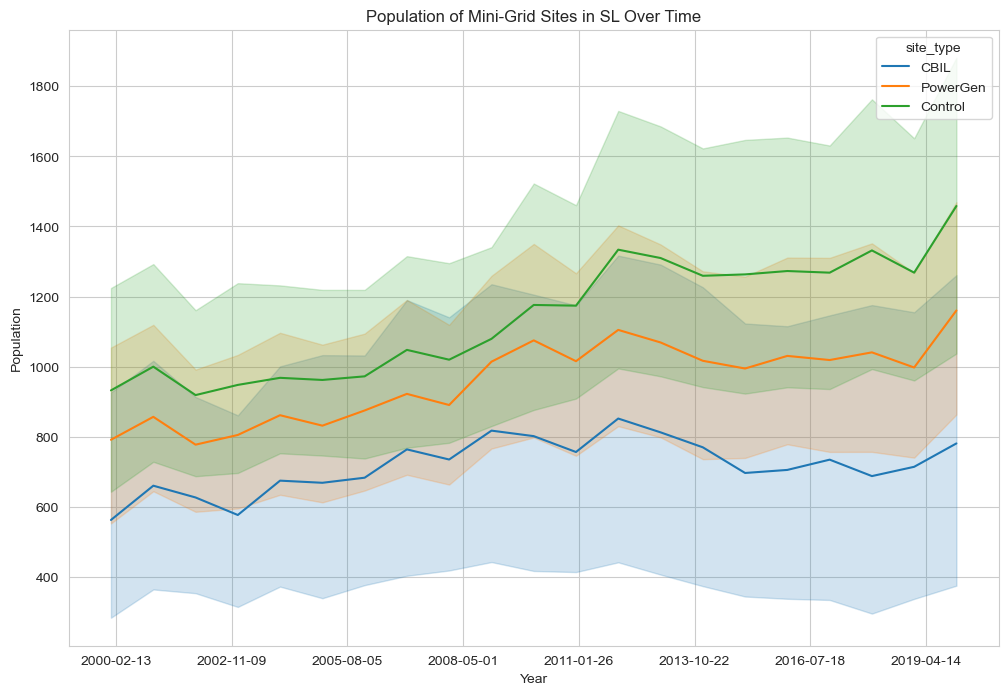

In [40]:
# import the gdf pop data
gdf = gpd.read_file('data/sl_pop/sl_pop_melt.geojson')

# set the style
sns.set_style('whitegrid')

# create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# plot the population of each site over time
sns.lineplot(data=gdf, x='year', y='population', hue='site_type', ax=ax)

# set the title
ax.set_title('Population of Mini-Grid Sites in SL Over Time')

# set the x-axis label
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# set the y-axis label
ax.set_ylabel('Population')

# show the plot
plt.show()